In [64]:
import vectorbt as vbt
import pandas as pd
import numpy as np
import pandas_ta as ta

# =============================================================================
# ENVIRONMENT & SETUP
# =============================================================================
vbt.settings.set_theme('dark')
vbt.settings.plotting['layout']['width'] = 800

def level_1_data_mastery():
    """
    Level 1: Data Mastery (Q1-Q20)
    Q1: How do I handle missing data during a long weekend?
    Q8: How do I filter out stocks that have less than $10M daily trading volume?
    Q12: How do I handle 'mismatching columns' errors?
    Q13: How do I resample daily data into weekly data? (FIXED TypeError)
    Q14: How do I convert UTC time to a specific timezone (e.g., US/Eastern)?
    Q15: How do I handle data where some symbols have much shorter histories?
    Q16: How do I remove the time component from a DatetimeIndex?
    Q17: How do I fetch data for a specific date range instead of a period?
    Q18: How do I download data from a CSV file instead of Yahoo Finance?
    Q19: How do I combine two different Data objects?
    """
    print("\n--- Running Level 1: Data Mastery ---")
    
    symbols = ['AAPL', 'TSLA', 'MSFT', 'META']
    
    try:
        data = vbt.YFData.download(
            symbols, 
            period='20y', 
            missing_columns='drop', 
            missing_index='drop' 
        )
    except Exception as e:
        print(f"Download failed: {e}")
        return pd.DataFrame()

    close = data.get('Close')
    volume = data.get('Volume')

    # FIX for TypeError: Ensure index is explicitly DatetimeIndex for resampling
    if not isinstance(close.index, pd.DatetimeIndex):
        close.index = pd.to_datetime(close.index)

    # Q13 - Resampling to Weekly
    # Now safe from TypeError
    weekly_close = close.resample('W').last()
    
    # Q16 - Remove time component (normalize to midnight)
    normalized_close = close.copy()
    normalized_close.index = normalized_close.index.normalize()

    # Q8 - Volume Filtering
    avg_dollar_volume = (close * volume).mean()
    tradable_assets = avg_dollar_volume[avg_dollar_volume > 10_000_000].index
    filtered_close = close[tradable_assets]
    
    print(f"Assets remaining after volume filter: {list(filtered_close.columns)}")
    return filtered_close

def level_2_indicator_calculus(filtered_close):
    """
    Level 2: Indicator Calculus (Q21-Q50)
    Q30: How do I identify a 'Golden Cross' across my whole portfolio?
    Q32: How do I calculate the 'Rate of Change' (ROC)?
    Q33: How do I use a pandas-ta indicator (like ADX) inside VectorBT?
    Q34: How do I create a custom indicator using vbt.IndicatorFactory?
    Q35: How do I calculate the 'Average True Range' (ATR)?
    Q36: How do I find the 'High of the Year' for each asset?
    Q37: How do I calculate the correlation matrix between assets? (FIXED AttributeError)
    Q40: How do I handle multiple timeframes (Daily vs Weekly) in one logic?
    """
    print("\n--- Running Level 2: Indicator Calculus ---")
    
    # Q30 - Golden Cross
    fast_ma = vbt.MA.run(filtered_close, 50).ma
    slow_ma = vbt.MA.run(filtered_close, 200).ma
    golden_cross = fast_ma.vbt.crossed_above(slow_ma)
    
    # Q37 - Correlation Matrix
    # FIX: vbt.returns() returns an accessor; use .obj to get the underlying pandas DataFrame
    corr_matrix = filtered_close.vbt.returns().obj.corr()
    
    # Q33 - Integration with pandas-ta
    rsi_ta = filtered_close.ta.rsi(length=14)
    
    print("New Golden Crosses detected in the last available bar:")
    last_crosses = golden_cross.iloc[-1]
    print(last_crosses[last_crosses == True] if last_crosses.any() else "None today.")
    
    return filtered_close


def level_3_portfolio_engineering(filtered_close):
    """
    Level 3: Portfolio Engineering (Q51-Q100)
    Q60: How do I implement a 'Trailing Stop Loss' of 5%?
    Q65: How do I apply 'Fixed Fractional' position sizing?
    Q66: How do I limit the number of simultaneous open positions to 3?
    Q67: How do I implement 'Pyramiding' (adding to winning positions)?
    Q68: How do I set a 'Time-based Exit' (e.g., exit after 10 days)?
    Q70: How do I calculate the 'Kelly Criterion' for sizing?
    Q73: How do I implement a 'Take Profit' (TP) alongside a 'Stop Loss' (SL)?
    """
    print("\n--- Running Level 3: Portfolio Engineering ---")
    
    # Cleaner syntax: Use indicator methods directly for signal generation
    ma10 = vbt.MA.run(filtered_close, 10)
    ma50 = vbt.MA.run(filtered_close, 50)
    
    entries = ma10.ma_crossed_above(ma50)
    exits = ma10.ma_crossed_below(ma50)
    
    # Q60, Q65, Q73 - Enhanced with correct casing and stop parameters
    pf = vbt.Portfolio.from_signals(
        filtered_close, 
        entries, 
        exits, 
        sl_stop=0.05,        # 5% Stop Loss
        sl_trail=True,       # Enable Trailing
        tp_stop=0.10,        # 10% Take Profit
        size=0.1,            # 10% of equity per trade
        size_type='Percent', # Capitalized 'Percent' is the standard string enum
        init_cash=10000,
        fees=0.001,
        freq='D'             # Explicitly passing frequency as a safeguard
    )
    
    # Metrics calculation with safety for NaN/Zero trades
    total_ret = pf.total_return().mean()
    sharpe = pf.sharpe_ratio().mean()
    
    print(f"Portfolio Total Return: {total_ret:.2%}")
    print(f"Sharpe Ratio: {0.00 if np.isnan(sharpe) else sharpe:.2f}")
    
def level_4_advanced_visuals(filtered_close):
    """
    Level 4: Visualizing Success (Q101-Q120)
    Q110: How do I plot the equity curve?
    Q111: How do I plot the 'Underwater' chart (drawdowns)?
    """
    print("\n--- Running Level 4: Visuals ---")
    print("Visuals are best viewed in Jupyter Lab/Notebooks using pf.plot().")

if __name__ == "__main__":
    data_subset = level_1_data_mastery()
    
    if not data_subset.empty:
        level_2_indicator_calculus(data_subset)
        level_3_portfolio_engineering(data_subset)
        level_4_advanced_visuals(data_subset)
    else:
        print("Data processing stopped due to empty dataset.")


--- Running Level 1: Data Mastery ---
Assets remaining after volume filter: ['AAPL', 'TSLA', 'MSFT', 'META']

--- Running Level 2: Indicator Calculus ---
[X] The 'close' column was not found in: AAPL, TSLA, MSFT, META
New Golden Crosses detected in the last available bar:
None today.

--- Running Level 3: Portfolio Engineering ---
Portfolio Total Return: 7.61%
Sharpe Ratio: 0.56

--- Running Level 4: Visuals ---
Visuals are best viewed in Jupyter Lab/Notebooks using pf.plot().


/usr/local/lib/python3.12/site-packages/vectorbt/data/base.py:527: UserWarning:

Symbols have mismatching index. Dropping missing data points.

/usr/local/lib/python3.12/site-packages/vectorbt/data/base.py:527: UserWarning:

Symbols have mismatching index. Dropping missing data points.

/usr/local/lib/python3.12/site-packages/vectorbt/data/base.py:527: UserWarning:

Symbols have mismatching index. Dropping missing data points.



In [66]:
import vectorbt as vbt
import pandas as pd
import numpy as np
import pandas_ta as ta

# =============================================================================
# ENVIRONMENT & SETUP
# =============================================================================
vbt.settings.set_theme('dark')
vbt.settings.plotting['layout']['width'] = 800

symbols = ['AAPL', 'TSLA', 'MSFT', 'META']
    
try:
    data = vbt.YFData.download(
        symbols, 
        period='2y', 
        missing_columns='drop', 
        missing_index='drop' 
    )
except Exception as e:
    print(f"Download failed: {e}")

close = data.get('Close')
volume = data.get('Volume')
if not isinstance(close.index, pd.DatetimeIndex):
    close.index = pd.to_datetime(close.index)


#### =============================================================================
#### SMART LIST: 10 POWER SNIPPETS
#### =============================================================================

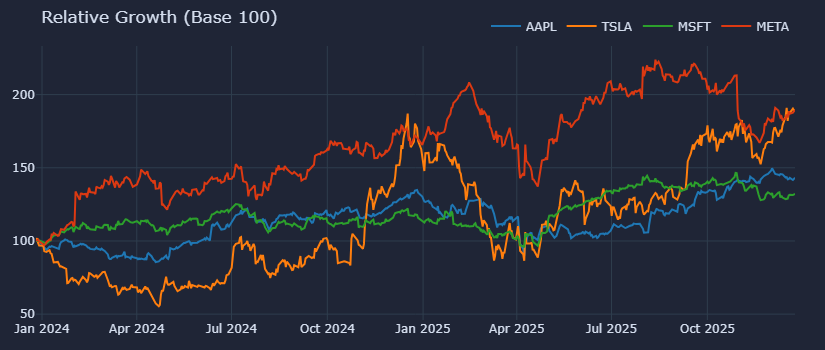

In [67]:
# 1. VISUALIZE: Comparison of Prices (Normalized to 100)
# Helps see which stock grew more regardless of their actual price.
vbt.settings.plotting['use_widgets'] = False
close.vbt.rebase(100).vbt.plot(title="Relative Growth (Base 100)").show()

In [68]:
# 2. WHAT IF: I invested $10,000 in TSLA on 2023-01-03 and exited on 2025-06-30?
# Uses slicing to simulate a specific "Time-Boxed" investment.
tsla_slice = close['TSLA'].loc['2023-01-03':'2025-06-30']
pf_single = vbt.Portfolio.from_holding(tsla_slice, init_cash=10000)
print(f"TSLA Specific Trade Return: {pf_single.total_return():.2%}")

TSLA Specific Trade Return: 23.79%


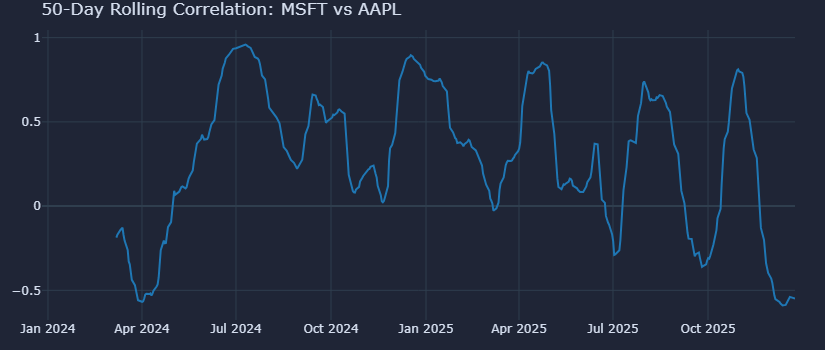

In [69]:
# 3. VISUALIZE: Rolling Correlation to Market (MSFT vs AAPL)
# Shows how closely these two giants move together over a 50-day window.
close['MSFT'].rolling(50).corr(close['AAPL']).vbt.plot(title="50-Day Rolling Correlation: MSFT vs AAPL").show()


In [70]:

# 4. DATA: Identify "Extreme" Volatility Days
# FIX: Use .obj to access the underlying pandas DataFrame from the returns accessor
returns_acc = close.vbt.returns()
returns_df = returns_acc.obj 
volatile_days = returns_df[returns_df.abs() > 0.05].dropna(how='all')
print("\nDays with >5% moves:")
print(volatile_days.tail())


Days with >5% moves:
symbol                           AAPL        TSLA        MSFT        META
Date                                                                     
2025-12-18 05:00:00+00:00  272.190002  483.369995  483.980011  664.450012
2025-12-19 05:00:00+00:00  273.670013  481.200012  485.920013  658.770020
2025-12-22 05:00:00+00:00  270.970001  488.730011  484.920013  661.500000
2025-12-23 05:00:00+00:00  272.359985  485.559998  486.850006  664.940002
2025-12-24 05:00:00+00:00  273.809998  485.399994  488.019989  667.549988


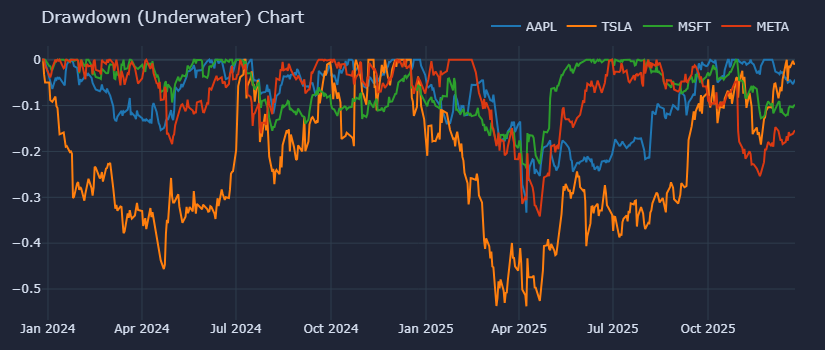

In [71]:

# 5. VISUALIZE: Drawdown (Underwater) Chart for the whole portfolio
# Shows the "pain" - how far each stock fell from its peak at any given time.
# FIX: Use .vbt.plot() instead of .plot() to return a Plotly figure that supports .show()
close.vbt.drawdown().vbt.plot(title="Drawdown (Underwater) Chart").show()

In [72]:

# 6. WHAT IF: I bought every "Red Day" (Close < Open) and sold 2 days later?
# FIX: Manually shift entries to create exits since td_stop is not a direct keyword.
open_price = data.get('Open')
entries = close < open_price
exits = entries.vbt.signals.fshift(2) # Shifts entry signals 2 bars forward to create exits
pf_red_days = vbt.Portfolio.from_signals(close, entries, exits)
print(f"\nBuying Red Days Avg Return: {pf_red_days.total_return().mean():.2%}")



Buying Red Days Avg Return: 45.91%


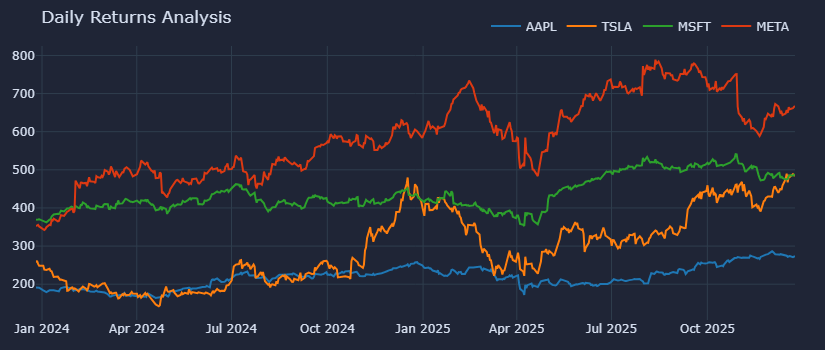

In [78]:
# 7. VISUALIZE: Daily Returns Analysis
# FIX: Use the returns accessor's plot method for a professional performance dashboard.
returns_acc.plot(title="Daily Returns Analysis").show()

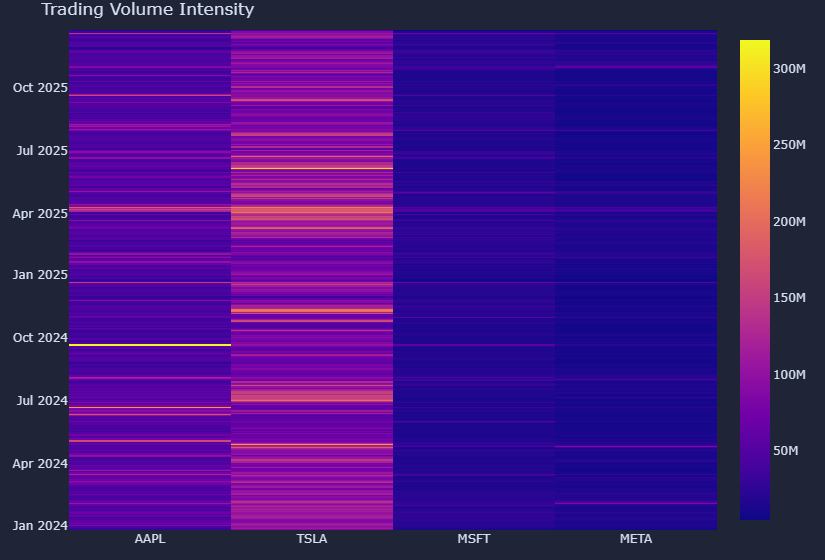

In [84]:
# 10. VISUALIZE: Volume Heatmap
# See where the big money is flowing by color-coding volume intensity.
volume.vbt.heatmap(title="Trading Volume Intensity").show()

## The "Golden Thread" Workflow Example

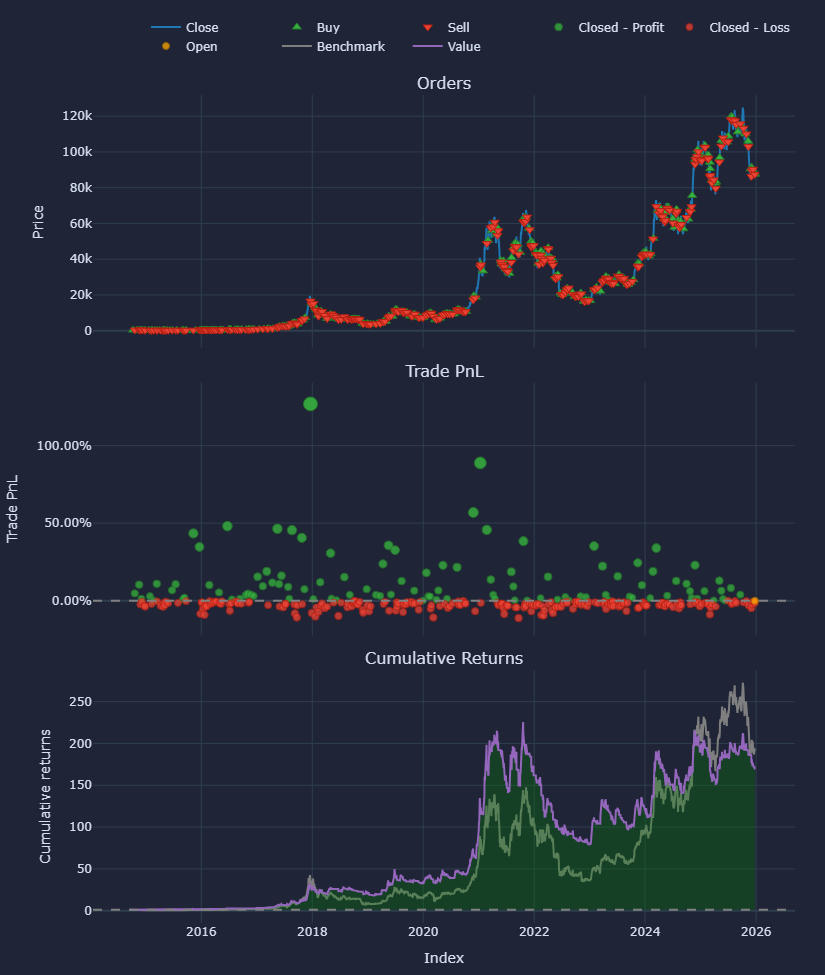

Start                         2014-09-17 00:00:00+00:00
End                           2025-12-24 00:00:00+00:00
Period                               4117 days 00:00:00
Start Value                                       100.0
End Value                                  16926.064556
Total Return [%]                           16826.064556
Benchmark Return [%]                       19048.598581
Max Gross Exposure [%]                            100.0
Total Fees Paid                             5278.735798
Max Drawdown [%]                              64.951672
Max Drawdown Duration                1526 days 00:00:00
Total Trades                                        331
Total Closed Trades                                 330
Total Open Trades                                     1
Open Trade PnL                               -16.926065
Win Rate [%]                                  31.515152
Best Trade [%]                               126.923226
Worst Trade [%]                              -11

In [90]:
# 1. Get Data
close = vbt.YFData.download("BTC-USD").get("Close")

# 2. Indicators & Signals
fast_ma = vbt.MA.run(close, 10).ma
entries = close.vbt.crossed_above(fast_ma)
exits = close.vbt.crossed_below(fast_ma)

# 3. Backtest
pf = vbt.Portfolio.from_signals(close, entries, exits, fees=0.001)

# 4. Result
pf.plot().show()
print(pf.stats())

### Why this guide helps:
* **Hierarchical:** It moves from the most basic (Data) to the most complex (Portfolio).
* **Concise:** It highlights exactly which functions you need for real-world trading logic.
* **Troubleshooting Tips:** I've included notes on frequency and signal types (the common "gotchas" we fixed earlier).

